# Extract Meta Data from raw and postISRCCD

 work with Weakly_2022_39
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/11/02
- update : 2022/11/02


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/atmospec 	setup
drp_pipe              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/drp_pipe 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/eups 	setup
summit_utils          LOCAL:/home/d/dagoret/repos/repos_w_2022_39/summit_utils 	setup


In [2]:
! eups list -s lsst_distrib

   g0b29ad24fb+a10408d0bf 	current w_2022_39 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

# Pipeline tasks from DP0.2
#from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
#from lsst.meas.algorithms.detection import SourceDetectionTask
#from lsst.meas.deblender import SourceDeblendTask
#from lsst.meas.base import SingleFrameMeasurementTask

# fromm StackClub on Britter-Fatter
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
import lsst.meas.extensions.shapeHSM
from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
repo =  "/sdf/group/rubin/repo/main"
#repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

## Give the collection

In [9]:
my_collection = "u/dagoret/spectro/noflat/empty~holo4/20211103"

In [10]:
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

## Config

In [11]:
# path index for each month
DATE="20211103"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"

## Select the postISRCCD

In [12]:
datasetRefs = registry.queryDatasets(datasetType='postISRCCD', collections=my_collection, where= "instrument='LATISS'")

In [13]:
all_dataId = []
all_postisrccd  = []
all_exposures = []



for i, ref in enumerate(datasetRefs):
   
    print(f"========({i})================datasetType = postISRCCD ============================================")
    print("fullId..................:",ref.dataId.full)
    print("exposure................:",ref.dataId["exposure"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    the_exposure = ref.dataId["exposure"]
    the_day_obs = ref.dataId["exposure"]//100_000
    the_seq_num = ref.dataId["exposure"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    #spec       = butler.get('spectraction',the_dataId)
    postisrccd = butler.get('postISRCCD', exposure=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_postisrccd.append(postisrccd)
    if i >= 0:
        break

========(0)================datasetType = postISRCCD ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', exposure: 2021110300459}
exposure................: 2021110300459
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20211103/20221031T154824Z
{'day_obs': 20211103, 'seq_num': 459, 'detector': 0}


In [14]:
all_exposures

[2021110300459]

<Figure size 600x600 with 0 Axes>

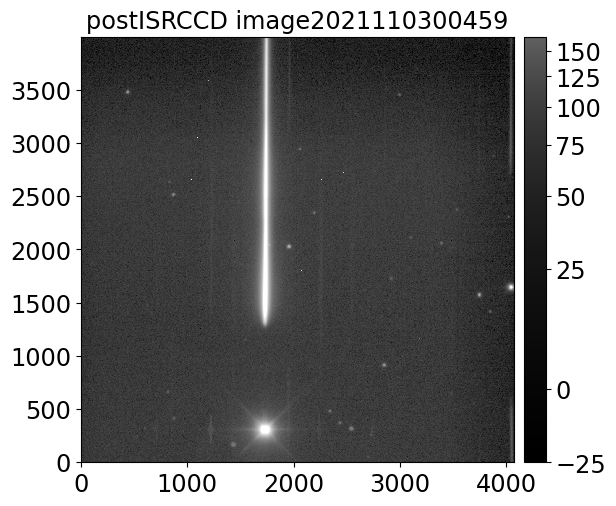

In [15]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
title = 'postISRCCD image' + str(all_exposures[-1]) 
afw_display.mtv(postisrccd.image,title=title)

<Figure size 600x600 with 0 Axes>

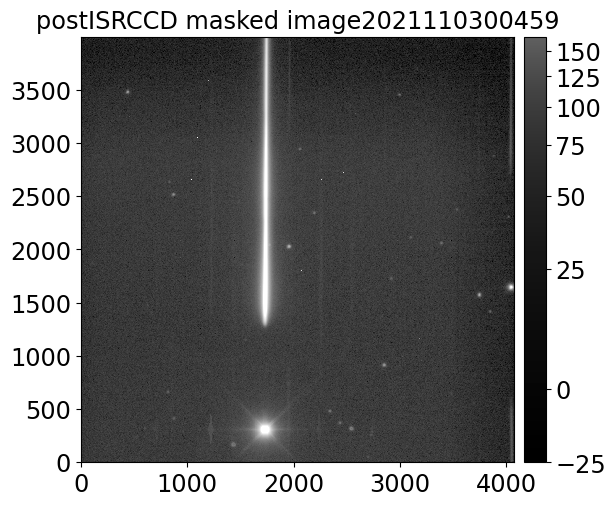

In [16]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
title = 'postISRCCD masked image' + str(all_exposures[-1]) 
afw_display.mtv(postisrccd.maskedImage.image,title=title)

### Get raw image

In [19]:
raw = butler.get('raw', exposure=all_exposures[-1], detector=0, collections=my_collection, instrument='LATISS')

/sdf/group/rubin/lsstdata/offline/instrument/LATISS/storage/2021-11-03/AT_O_20211103_000459-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


In [20]:
raw_md = dict(raw.getMetadata())
raw_md

{'SIMPLE': True,
 'EXTEND': True,
 'COMMENT': '---- Geometry from Camera ----',
 'ORIGIN': 'LSST DM Header Service',
 'TIMESYS': 'TAI',
 'DATE': '2021-11-04T05:23:11.018',
 'DATE-OBS': '2021-11-04T05:23:15.100',
 'DATE-BEG': '2021-11-04T05:23:15.100',
 'DATE-END': '2021-11-04T05:23:45.334',
 'MJD': 59522.2244330786,
 'MJD-OBS': 59522.2244803223,
 'MJD-BEG': 59522.2244803223,
 'MJD-END': 59522.22483025,
 'OBSID': 'AT_O_20211103_000459',
 'GROUPID': '2021-11-04T05:22:01.808',
 'IMGTYPE': 'OBJECT',
 'BUNIT': 'adu',
 'FACILITY': 'Vera C. Rubin Observatory',
 'TELESCOP': 'LSST AuxTelescope',
 'INSTRUME': 'LATISS',
 'OBSERVER': 'LSST',
 'OBS-LONG': -70.749417,
 'OBS-LAT': -30.244639,
 'OBS-ELEV': 2663.0,
 'OBSGEO-X': 1818938.94,
 'OBSGEO-Y': -5208470.95,
 'OBSGEO-Z': -3195172.08,
 'RA': 86.49956375,
 'DEC': -32.3064344444444,
 'RASTART': 86.5085145406436,
 'DECSTART': -32.2706406469849,
 'RAEND': 86.5086561465611,
 'DECEND': -32.270614566394,
 'ROTPA': 354.723744971664,
 'ROTCOORD': 'sky',
 

In [21]:
postisrccd_md = dict(postisrccd.getMetadata())
postisrccd_md 

{'COMMENT': '---- Geometry from Camera ----',
 'ORIGIN': 'LSST DM Header Service',
 'DATE': '2021-11-04T05:23:11.018',
 'DATE-BEG': '2021-11-04T05:23:15.100',
 'DATE-END': '2021-11-04T05:23:45.334',
 'MJD': 59522.2244330786,
 'MJD-BEG': 59522.2244803223,
 'MJD-END': 59522.22483025,
 'OBSID': 'AT_O_20211103_000459',
 'GROUPID': '2021-11-04T05:22:01.808',
 'IMGTYPE': 'OBJECT',
 'BUNIT': 'adu',
 'FACILITY': 'Vera C. Rubin Observatory',
 'TELESCOP': 'LSST AuxTelescope',
 'INSTRUME': 'LATISS',
 'OBSERVER': 'LSST',
 'OBSGEO-X': 1818938.94,
 'OBSGEO-Y': -5208470.95,
 'OBSGEO-Z': -3195172.08,
 'RA': 86.49956375,
 'DEC': -32.3064344444444,
 'RASTART': 86.5085145406436,
 'DECSTART': -32.2706406469849,
 'RAEND': 86.5086561465611,
 'DECEND': -32.270614566394,
 'ROTPA': 354.723744971664,
 'ROTCOORD': 'sky',
 'HASTART': -2.20837808950269,
 'ELSTART': 61.7579201444023,
 'AZSTART': 102.707592774648,
 'AMSTART': 1.13475219515744,
 'HAEND': -2.19923436340429,
 'ELEND': 61.8739837988251,
 'AZEND': 102.68

In [26]:
ccd_ymax=postisrccd.getBBox().getMaxY()
ccd_xmax=postisrccd.getBBox().getMaxX()

In [27]:
postisrccd.image.array.flatten()

array([18.209455 , 22.509457 , -6.9405437, ..., -1.8026681,  2.2607079,
        3.3668232], dtype=float32)

Text(0.5, 1.0, 'distribution of pixel value in postISRCCD')

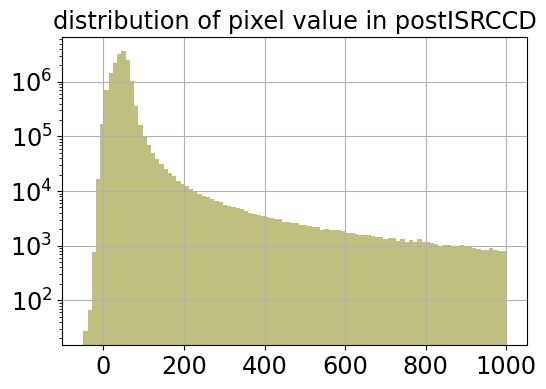

In [28]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(postisrccd.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor='blue')
ax.hist(postisrccd.maskedImage.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor="yellow")
ax.set_yscale('log')
ax.grid()
ax.set_title("distribution of pixel value in postISRCCD")